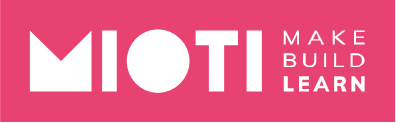
<br/>
<center style="color:#888">Master Deep Learning<br/>Asignatura Computer Vision</center>
<center style="color:#aaa; margin-top:10px;">Prof. Óscar Picazo Montoya<br>oscarpm@faculty.mioti.es</center>


# Challenge S6: Reconociendo objetos en tiempo real

## Objetivos

El objetivo de este worksheet es que implementemos un reconocedor de objetos que sea capaz de procesar una fuente de vídeo en tiempo real.

## Prerrequisitos

Para realizar este challenge deberás tener instalados los paquetes del worksheet y también tener una webcam en tu ordenador (existe la opción de hacerlo con un vídeo si no tienes una webcam disponible).

## Configuración del entorno

In [26]:
# !pip install keras
# !pip install tensorflow

In [25]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data, io, filters
from skimage import transform

from IPython import display

from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten

import warnings
warnings.filterwarnings("ignore")

from utils import dibujar_img, dibujar_imgs

## Captura de imágenes con la Webcam

Empezaremos el challenge aprendiendo como conectarnos a una webcam y siendo capaces de procesar los frames del video. Para ello utilizaremos `OpenCV` que es una de las bibliotecas de computer vision más conocidas. No te preocupes porque este paquete es una dependencia de `skimage` por lo que deberías tenerla ya instalada en tu máquina.

Podemos conectarnos a la webcam de la siguiente forma:

In [112]:
import cv2

# Elegimos el dispositivo de vídeo, por defecto 0 es el dispositivo principal.
cam = cv2.VideoCapture(0)

Una vez conectados podemos leer un frame de la cámara con `read`, esta función nos devolverá un código de devolución `ret` y el frame:

In [113]:
ret, frame = cam.read()

In [114]:
frame.shape

(480, 640, 3)

Una vez capturado el frame podemos parar de capturar con la webcam con:

In [115]:
cam.release()# Liberamos la imagen

Veamos ahora el frame que hemos obtenido:

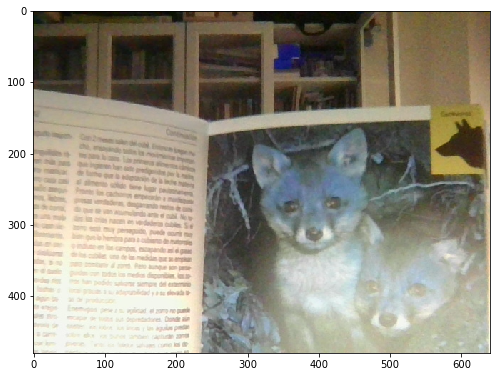

In [116]:
dibujar_img(frame)

¿Qué ves en la imagen?

Como podrás ver los colores están distorsionados y esto es porque internamente `opencv` en vez de ordenar los píxels en formato `RGB` los ordena en formato `BGR`. Para convertir un formato a otro podemos usar la función de `opencv` `cvtColor` que nos permite reordenar los canales:

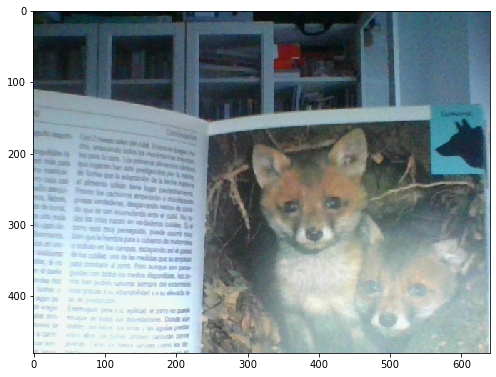

In [117]:
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
dibujar_img(frame_rgb)

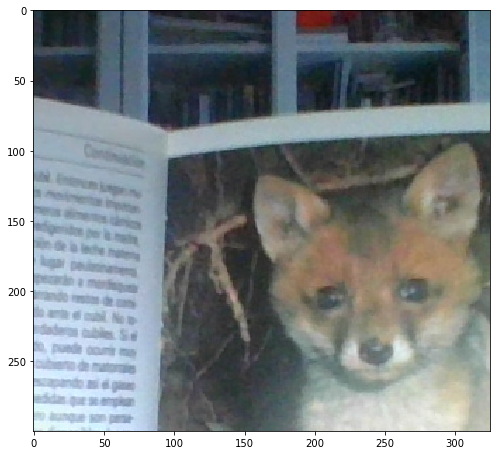

In [118]:
img_cropped = frame_rgb [70:370, 150:475]
img_resized = transform.resize(img_cropped, (299, 299), preserve_range=True).astype(np.ubyte)
dibujar_img(img_cropped)

### Mostrando frames en movimiento

Para mostrar una secuencia de video deberemos capturar de forma iterativa los frames e irlos mostrando en pantalla. Lo puedes ver en el siguiente ejemplo:

Predicted: [[('n02119022', 'red_fox', 0.12189695), ('n02113023', 'Pembroke', 0.07836645), ('n02119789', 'kit_fox', 0.057827324)]]
Secuencia de video parada:
	


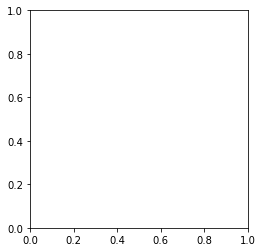

In [119]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
model = EfficientNetB0(weights='imagenet')


cam = cv2.VideoCapture(0)
try:
    while True:
        # Capturamos el frame
        ret, frame = cam.read()
        
        if not ret:
            raise Exception("Cannot capture frame.")
        
        # Lo convertimos de BGR a RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Limpiamos la salida anterior esperando al nuevo contenido
        display.clear_output(wait=True)
    
        # Haz lo que quieras con la imagen...
        
        # Hacemos un crop de la imagen para centrarla y evitar posbles deformaciones al hacer un rise de forma directa
        img_cropped = frame_rgb [70:370, 150:475]
        img_resized = transform.resize(img_cropped, (224, 224), preserve_range=True).astype(np.ubyte)
        img_expanded = np.expand_dims(img_resized, axis=0)
        img_preprocessed = preprocess_input(img_expanded)
        preds = model.predict(img_preprocessed)
        print('Predicted: {}'.format(decode_predictions(preds, top=3)))
        
        
        # Mostramos la imagen
        im = plt.imshow(frame_rgb, animated=True)
                    
        plt.show()
    
except KeyboardInterrupt as ex:
    # Si paramos el bloque cancelamos el stream de vídeo.
    cam.release()
    print("Secuencia de video parada:\n\t{}".format(ex))

## ¿Y si no tengo webcam o estoy en un entorno cloud sin acceso físico al equipo? ##

Si el equipo donde estás desarrollando el challenge no tiene acceso a una cámara, vamos a hacer algo equivalente a lo anterior pero leyendo un fichero de vídeo previamente grabado.<br /><br />
Como puedes ver, el código es muy similar al anterior.

In [120]:
cam = cv2.VideoCapture('video/s6.challenge.mp4')
try:
    while True:
        # Capturamos el frame
        ret, frame = cam.read()
        
        if not ret:
            raise Exception("Cannot capture frame.")
        
        # Lo convertimos de BGR a RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Limpiamos la salida anterior esperando al nuevo contenido
        display.clear_output(wait=True)
    
        # Haz lo que quieras con la imagen...
        
        # Mostramos la imagen
        im = plt.imshow(frame_rgb, animated=True)
                    
        plt.show()
    
except KeyboardInterrupt as ex:
    # Si paramos el bloque cancelamos el stream de vídeo.
    cam.release()
    print("Secuencia de video parada:\n\t{}".format(ex))

Secuencia de video parada:
	


## Reconociendo objetos en tiempo real

Una vez aquí ya tienes todo lo necesario para resolver este challenge. Deberás capturar cada frame, procesarlo, mostrar la salida y así por cada frame.

Si los resultados con `VGG19` no te convencen puedes probar cualquiera de los modelos preentrenados que se disponen en `Keras`: https://keras.io/applications/

* He elegido trabajar con una red InceptionV3. Esta red es de Google, y también esta entrenada con Imagenet. A diferencia de EfficientNetB0 esta trabaja con imagenes de 290x290.

In [18]:
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.applications.inception_v3 import InceptionV3

def identifier_image (model):
    
    cam = cv2.VideoCapture(0)
    try:
        while True:
            # Capturamos el frame
            ret, frame = cam.read()

            if not ret:
                raise Exception("Cannot capture frame.")

            # Lo convertimos de BGR a RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Limpiamos la salida anterior esperando al nuevo contenido
            display.clear_output(wait=True)

            # Haz lo que quieras con la imagen...

            img_cropped = frame_rgb [70:370, 150:475]
            img_resized = transform.resize(img_cropped, (299, 299), preserve_range=True).astype(np.ubyte)
            img_expanded = np.expand_dims(img_resized, axis=0)
            img_preprocessed = preprocess_input(img_expanded)
            preds = model.predict(img_preprocessed)
            print('Predicted: {}'.format(decode_predictions(preds, top=3)))


            # Mostramos la imagen
            im = plt.imshow(frame_rgb, animated=True)

            plt.show()

    except KeyboardInterrupt as ex:
        # Si paramos el bloque cancelamos el stream de vídeo.
        cam.release()
        print("Secuencia de video parada:\n\t{}".format(ex))
    
    return None

In [19]:
model = InceptionV3(weights='imagenet')
identifier_image(model)

Predicted: [[('n02870880', 'bookcase', 0.6586559), ('n03661043', 'library', 0.118325315), ('n02871525', 'bookshop', 0.05618713)]]
Secuencia de video parada:
	
